In [1]:
# going to just do a few cnns and try to automate different hyperparameter tunings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras import backend as k
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv2D, MaxPooling2D, Dense, Conv1D, Dropout
from keras.layers import MaxPooling1D, Flatten, Embedding, LSTM
from keras.models import Sequential
import spacy
import nltk
import en_core_web_md

Using TensorFlow backend.
C:\Users\TerrenceJEdmonds\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\TerrenceJEdmonds\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\TerrenceJEdmonds\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\TerrenceJEdmonds\Anaconda3\lib\site-pa

In [3]:
tweet_full_train_df = pd.read_csv('input/train.csv')
tweet_full_test_df = pd.read_csv('input/test.csv')

In [4]:
tweet_full_train_df.head()
train_test_size = 0.2

# may want to try messing with some of these values in CountVectorizer
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),
                            lowercase=True, min_df=3, max_df=0.9, max_features=5000)

#vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),
#                            lowercase=True, min_df=5, max_df=0.9, max_features=5000)

wv_data = vectorizer.fit_transform(tweet_full_train_df['text'].values)
wv_target = tweet_full_train_df['target'].values

data_train, data_validation, target_train, target_validation = train_test_split(
    tweet_full_train_df['text'].values ,tweet_full_train_df['target'].values,test_size=train_test_size)

In [5]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()

def to_sequence(tokenizer, preprocessor, index, text):
    
    words = tokenizer(preprocessor(text))
    #print(words)
    indexes = [index[word] for word in words if word in index]
    
    return indexes

print(to_sequence(tokenize, preprocess, word2idx, "this is an important test!"))
data_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_train]
data_test_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_validation]
print(data_train_sequences[0])

# but now we pad so that everything is the same length
MAX_SEQ_LENGTH = len(max(data_train_sequences, key=len))
if len(max(data_test_sequences, key=len)) > MAX_SEQ_LENGTH:
    MAX_SEQ_LENGTH = len(max(data_test_sequences, key=len))

print('MAX_SEQ_LENGTH=',MAX_SEQ_LENGTH)
N_FEATURES = len(vectorizer.get_feature_names())
print('N_FEATURES=',N_FEATURES)
data_train_sequences = pad_sequences(data_train_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
data_test_sequences = pad_sequences(data_test_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
print(data_train_sequences[0])

[3763]
[466, 454, 4235, 1069, 2304, 2391, 3613, 3025, 2250]
MAX_SEQ_LENGTH= 22
N_FEATURES= 4304
[4304 4304 4304 4304 4304 4304 4304 4304 4304 4304 4304 4304 4304  466
  454 4235 1069 2304 2391 3613 3025 2250]


In [8]:
def conv_model01():
    
    model = Sequential()
    
    model.add(Embedding(len(vectorizer.get_feature_names()) + 1, 64,
                       input_length=MAX_SEQ_LENGTH))
    
    model.add(Conv1D(64, 5, activation='relu',padding='same'))
    model.add(MaxPooling1D(5,padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(64,5,activation='relu',padding='same'))
    model.add(MaxPooling1D(5,padding='same'))
    
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    
    return model

sim_conv_model = conv_model01()

sim_conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(sim_conv_model.summary())


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 64)            275520    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 64)             20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 64)             0         
_________________________


Train on 5990 samples, validate on 100 samples
Epoch 1/7
5990/5990 [==============================] - ETA: 26s - loss: 0.6875 - accuracy: 0.587 - ETA: 4s - loss: 0.6868 - accuracy: 0.562 - ETA: 0s - loss: 0.6790 - accuracy: 0.56 - 3s 454us/step - loss: 0.6775 - accuracy: 0.5698 - val_loss: 0.6625 - val_accuracy: 0.5300
Epoch 2/7
5990/5990 [==============================] - ETA: 0s - loss: 0.6649 - accuracy: 0.55 - ETA: 0s - loss: 0.6498 - accuracy: 0.62 - 0s 17us/step - loss: 0.6417 - accuracy: 0.6399 - val_loss: 0.5926 - val_accuracy: 0.6800
Epoch 3/7
5990/5990 [==============================] - ETA: 0s - loss: 0.6056 - accuracy: 0.67 - ETA: 0s - loss: 0.5684 - accuracy: 0.72 - 0s 16us/step - loss: 0.5532 - accuracy: 0.7362 - val_loss: 0.4839 - val_accuracy: 0.8000
Epoch 4/7
5990/5990 [==============================] - ETA: 0s - loss: 0.4594 - accuracy: 0.79 - ETA: 0s - loss: 0.4083 - accuracy: 0.83 - 0s 17us/step - loss: 0.3904 - accuracy: 0.8404 - val_loss: 0.5064 - val_accuracy: 0

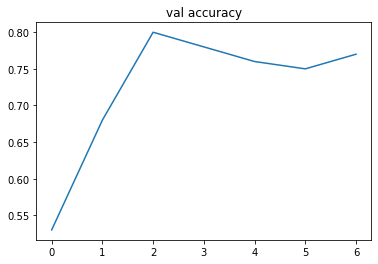

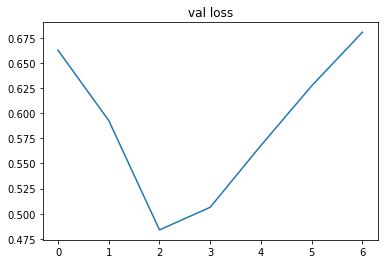

In [6]:

sim_conv_model = conv_model01()

sim_conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

sim_conv_model.fit(data_train_sequences[:-100],target_train[:-100],
                  epochs=7, batch_size=512, verbose=1,
                  validation_data=(data_train_sequences[-100:],target_train[-100:]))

plt.plot(sim_conv_model.history.history['val_accuracy'])
plt.title('val accuracy')
plt.show()

plt.plot(sim_conv_model.history.history['val_loss'])
plt.title('val loss')
plt.show()

In [7]:
scores = sim_conv_model.evaluate(data_test_sequences, target_validation, verbose=1)
print('Accuracy:', scores[1])

1523/1523 [==============================] - ETA:  - ETA:  - ETA:  - 0s 87us/step
Accuracy: 0.7826657891273499


In [9]:
# now I want to automate this for several steps in the epoch
def train_diff_epochs(model,num_epochs=8):
    
    ep_scores=[]
    
    for ep_idx in range(2,num_epochs):
        sim_conv_model = model

        sim_conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        sim_conv_model.fit(data_train_sequences[:-100],target_train[:-100],
                          epochs=ep_idx, batch_size=512, verbose=0,
                          validation_data=(data_train_sequences[-100:],target_train[-100:]))
        scores = sim_conv_model.evaluate(data_test_sequences, target_validation, verbose=1)
        ep_scores.append([ep_idx,scores[1]])
        print(ep_idx,'/',num_epochs-1)
    
    print(ep_scores)
    
    return

train_diff_epochs(model=conv_model01())


1523/1523 [==============================] - ETA:  - ETA:  - 0s 64us/step
2 / 7
1523/1523 [==============================] - ETA:  - ETA:  - ETA:  - 0s 75us/step
3 / 7
1523/1523 [==============================] - ETA:  - ETA:  - 0s 65us/step
4 / 7
1523/1523 [==============================] - ETA:  - ETA:  - 0s 70us/step
5 / 7
1523/1523 [==============================] - ETA:  - ETA:  - 0s 67us/step
6 / 7
1523/1523 [==============================] - ETA:  - ETA:  - ETA:  - 0s 88us/step
7 / 7
[[2, 0.7019041180610657], [3, 0.7997373342514038], [4, 0.777413010597229], [5, 0.7596848607063293], [6, 0.7452396750450134], [7, 0.7353906631469727]]


In [10]:
def conv_model02():
    
    model = Sequential()
    
    model.add(Embedding(len(vectorizer.get_feature_names()) + 1, 64,
                       input_length=MAX_SEQ_LENGTH))
    
    model.add(Conv1D(128, 5, activation='relu',padding='same'))
    #model.add(Dropout(0.25))
    model.add(MaxPooling1D(5,padding='same'))
    
    # second layer doesn't add anything in comparison to best train model version
    
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    
    return model

train_diff_epochs(model=conv_model02())

1523/1523 [==============================] - ETA:  - ETA:  - 0s 65us/step
2 / 7
1523/1523 [==============================] - ETA:  - ETA:  - 0s 58us/step
3 / 7
1523/1523 [==============================] - ETA:  - ETA:  - 0s 63us/step
4 / 7
1523/1523 [==============================] - ETA:  - ETA:  - 0s 63us/step
5 / 7
1523/1523 [==============================] - ETA:  - ETA:  - 0s 61us/step
6 / 7
1523/1523 [==============================] - ETA:  - ETA:  - 0s 66us/step
7 / 7
[[2, 0.7091267108917236], [3, 0.8023637533187866], [4, 0.7806959748268127], [5, 0.7623112201690674], [6, 0.734734058380127], [7, 0.7380170822143555]]


In [11]:
# okay, so just wrap this up and create a submission file

#tweet_full_test_df.head()
#data_test_sequences # technically validation

submit_model = conv_model02()
submit_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
submit_model.fit(data_train_sequences[:-100],target_train[:-100],
                          epochs=3, batch_size=512, verbose=0,
                          validation_data=(data_train_sequences[-100:],target_train[-100:]))
scores = submit_model.evaluate(data_test_sequences, target_validation, verbose=1)
print(scores[1])

1523/1523 [==============================] - ETA:  - ETA:  - 0s 64us/step
0.784635603427887


In [52]:
wv_submit = vectorizer.transform(tweet_full_test_df['text'].values)
#print(tweet_full_test_df['text'].values)
data_submit_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in tweet_full_test_df['text'].values]
#MAX_SEQ_LENGTH = len(max(data_submit_sequences,key=len))
data_submit_sequences = pad_sequences(data_submit_sequences, maxlen=MAX_SEQ_LENGTH,
                                      value=N_FEATURES)
predictions_cnn = submit_model.predict_classes(data_submit_sequences)
#print(predictions)
#print(tweet_full_test_df['text'][2])
pred_list_cnn = [predictions_cnn[pos][0] for pos in range(0,len(predictions_cnn))]
#print(pred_list)
print(tweet_full_test_df['id'].shape,predictions_cnn.shape)
pred_dict = {'id':tweet_full_test_df['id'].values,'target':list(pred_list_cnn)}
#final_frame = pd.DataFrame([tweet_full_test_df['id'].values,predictions],columns=['id,target'])
preds_df = pd.DataFrame(pred_dict,columns=['id','target'])
preds_df.to_csv('input/submission01.csv',index=False)
#preds_df = preds_df.drop(index=label)
#preds_df.head()

(3263,) (3263, 1)


,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [53]:
# lets throw in other models
def simple_cv_model():
    # just a simple model
    
    model = Sequential()
    
    model.add(Dense(units=500, activation='relu', input_dim=len(vectorizer.get_feature_names())))
    model.add(Dense(units=1, activation='sigmoid'))
    
    return model

In [55]:
data_train_cv = vectorizer.fit_transform(data_train)
data_valid_cv = vectorizer.transform(data_validation)

simple_countvec = simple_cv_model()
simple_countvec.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

simple_countvec.fit(data_train_cv[:-100],target_train[:-100],
          epochs=2, batch_size=128, verbose=1,
         validation_data=(data_valid_cv,target_validation))

Train on 5990 samples, validate on 1523 samples
Epoch 1/2
5990/5990 [==============================] - ETA: 8s - loss: 0.6980 - accuracy: 0.46 - ETA: 1s - loss: 0.6829 - accuracy: 0.57 - ETA: 0s - loss: 0.6699 - accuracy: 0.62 - ETA: 0s - loss: 0.6503 - accuracy: 0.67 - ETA: 0s - loss: 0.6333 - accuracy: 0.69 - ETA: 0s - loss: 0.6168 - accuracy: 0.70 - ETA: 0s - loss: 0.6019 - accuracy: 0.71 - ETA: 0s - loss: 0.5832 - accuracy: 0.73 - 1s 139us/step - loss: 0.5667 - accuracy: 0.7414 - val_loss: 0.4507 - val_accuracy: 0.8135
Epoch 2/2
1523/1523 [==============================] - ETA:  - ETA:  - ETA:  - 0s 91us/step


In [59]:
scores = simple_countvec.evaluate(data_valid_cv,target_validation)
print(scores[1])

wv_submit = vectorizer.transform(tweet_full_test_df['text'].values)

predictions_fcn = simple_countvec.predict_classes(wv_submit) 
# [predictions_cnn[pos][0] for pos in range(0,len(predictions_cnn))]
pred_list_fcn = [predictions_fcn[pos][0] for pos in range(0,len(predictions_fcn))]
#print(pred_list_fcn)

1523/1523 [==============================] - ETA:  - ETA:  - ETA:  - 0s 101us/step
0.8056467771530151


<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x000001C8C3B8F630>>


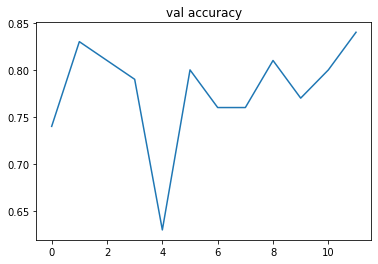

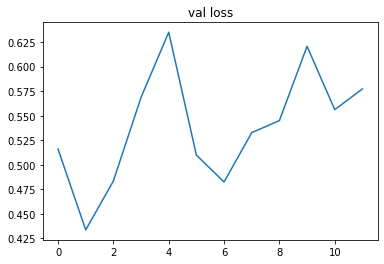

In [68]:
# and add in a third model, lstm

def lstm_model():
    
    model = Sequential()
    
    model.add(Embedding(len(vectorizer.get_feature_names()) +1, 64, input_length=MAX_SEQ_LENGTH))
    
    model.add(LSTM(128))
    model.add(Dense(units=1, activation='sigmoid'))
    
    return model

sim_lstm_mod = lstm_model()
sim_lstm_mod.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(sim_lstm_mod.summary)

sim_lstm_mod.fit(data_train_sequences[:-100],target_train[:-100],
                epochs=12, batch_size=128, verbose=0,
                validation_data=(data_train_sequences[-100:],target_train[-100:]))

plt.plot(sim_lstm_mod.history.history['val_accuracy'])
plt.title('val accuracy')
plt.show()

plt.plot(sim_lstm_mod.history.history['val_loss'])
plt.title('val loss')
plt.show()

In [71]:
scores_lstm = sim_lstm_mod.evaluate(data_test_sequences,target_validation)
print(scores_lstm[1])

predictions_lstm = sim_lstm_mod.predict_classes(data_submit_sequences)
pred_list_lstm = [predictions_lstm[pos][0] for pos in range(0,len(predictions_lstm))]
#print(pred_list_lstm)

1523/1523 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 383us/step
0.7623112201690674


In [77]:
# different prediction lists
#pred_list
#pred_list_fcn
#pred_list_lstm

#print(sum(pred_list),sum(pred_list_fcn),sum(pred_list_lstm))

# compare values in predictions

combined_preds = []
for i in range(0,len(pred_list)):
    mid_sum = pred_list[i] + pred_list_fcn[i] + pred_list_lstm[i]
    if mid_sum>=2:
        combined_preds.append(1)
    elif mid_sum < 2:
        combined_preds.append(0)
#print(combined_preds)

pred_dict_combined = {'id':tweet_full_test_df['id'].values,'target':combined_preds}
preds_combined_df = pd.DataFrame(pred_dict_combined,columns=['id','target'])
preds_combined_df.to_csv('input/combined_submission01.csv',index=False)

The combination of the models gave an improvement, but only a very small improvement. So most of the models are likely failing in the same place. May need to try a different embedding, or put more effort into cleaning the text

some ideas from this kernel 
https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert
https://www.kaggle.com/gauthampughazh/disaster-or-not-plotly-use-tfidf-h2o-ai-automl